In [1]:
########## import ##########
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tfdone import done
print('successfully imported')

successfully imported


In [2]:
########## backbone model ##########
# ** NOTE **
# I recommend using Vision Transformer (ViT) as a backbone model for DONE,
# but for simplicity I here use EfficientNet, which is included in TensorFlow.
# When using ViT, for example, I have confirmed vit-keras works: 
# INSTALLATION: pip install vit-keras
# IMPORT: from vit_keras import vit
# USAGE: model = vit.vit_b32()

model = tf.keras.applications.efficientnet.EfficientNetB0()
insize = model.input_shape[1:3]
print('model output shape =', model.output_shape)

model output shape = (None, 1000)


In [3]:
########## Example data load ##########
# CIFAR-100
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
# labels
(label_imnet, label_cifar10, label_cifar100) = done.load_labels()
print(f'ImNet_len={len(label_imnet)}; CIFAR10_len={len(label_cifar10)}; CIFAR100_len={len(label_cifar100)}')

ImNet_len=1000; CIFAR10_len=10; CIFAR100_len=100


images shape (num_images, height, width, channels) = (6, 32, 32, 3)
add_y shape (num_images) = (6,)


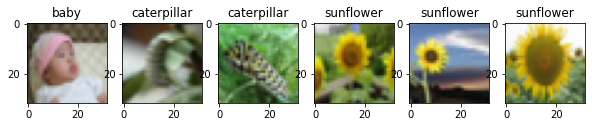

In [4]:
########## set training images for class addition ##########
# Let's say, we have 1, 2, 3 images of baby, caterpillar, sunflower.
add_y = np.array([0,1,1,2,2,2])
images = x_train[[202,75,89,12,164,274]].copy()
label_add = np.array(['baby', 'caterpillar', 'sunflower'])
label_imnet_add = np.append( label_imnet, np.array(label_add) )

plt.figure(figsize=(10,2))
for i in range(len(images)):
    plt.subplot(1,len(images),i+1)
    plt.imshow(images[i])
    plt.title(label_add[add_y[i]])

print('images shape (num_images, height, width, channels) =',images.shape)
print('add_y shape (num_images) =', add_y.shape)

In [5]:
########## Resize & preprocess training images ##########
images_resized = tf.image.resize(images, insize)
images_processed = tf.keras.applications.efficientnet.preprocess_input(images_resized)
print('images_processed shape (num_images, height, width, channels) =', images_processed.shape)

images_processed shape (num_images, height, width, channels) = (6, 224, 224, 3)


In [6]:
########## Class addition by DONE ##########
model_add = done.add_class( model, images_processed, add_y)
print('It\'s DONE! New classed added; model_add output shape =', model_add.output_shape)

It's DONE! New classed added; model_add output shape = (None, 1003)


input a baby image in CIFAR-test (a new class)
model_ori; TopID=680, nipple, y-val=0.11533
model_add; TopID=1000, baby, y-val=0.99353


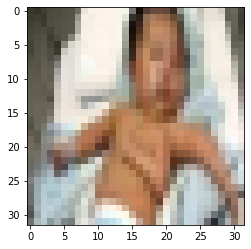

In [7]:
########## Test the class-added model; a new class baby image ##########

# Test by CIFAR baby image (no in original ImageNet class)
print('input a baby image in CIFAR-test (a new class)')

x = x_test[573,:,:,:]
plt.imshow(x)
x = tf.image.resize(x, insize)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x_baby = np.expand_dims(x, 0)

# prediction by original model 
y = model.predict(x_baby)[0]
print(f'model_ori; TopID={y.argmax()}, {label_imnet_add[y.argmax()]}, y-val={y.max():.5f}' )

# prediction by added model
y = model_add.predict(x_baby)[0]
print(f'model_add; TopID={y.argmax()}, {label_imnet_add[y.argmax()]}, y-val={y.max():.5f}' )


input a lion image in CIFAR-test (already in the imagenet classes)
model_ori; TopID=291, lion, y-val=0.89593
model_add; TopID=291, lion, y-val=0.89593


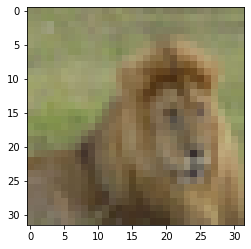

In [8]:
########## Test the class-added model; an original class lion image ##########

# Test by CIFAR Lion image
print('input a lion image in CIFAR-test (already in the imagenet classes)')

x = x_test[15,:,:,:]
plt.imshow(x)
x = tf.image.resize(x, insize)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x_lion = np.expand_dims(x, 0)

# prediction by original model
y = model.predict(x_lion)[0]
print(f'model_ori; TopID={y.argmax()}, {label_imnet_add[y.argmax()]}, y-val={y.max():.5f}' )

# prediction by added model
y = model_add.predict(x_lion)[0]
y = y/y[:1000].sum()  # For providing the same answer (correction for the softmax)
print(f'model_add; TopID={y.argmax()}, {label_imnet_add[y.argmax()]}, y-val={y.max():.5f}' )


In [9]:
########################################
########## Transfer learning ##########
########################################

In [10]:
########## Sample data load ##########
# CIFAR-10
(x_train_10, y_train_10), (x_test_10, y_test_10) = tf.keras.datasets.cifar10.load_data()
# labels
(label_imnet, label_cifar10, label_cifar100) = done.load_labels()
print(f'ImNet_len={len(label_imnet)}; CIFAR10_len={len(label_cifar10)}; CIFAR100_len={len(label_cifar100)}')

ImNet_len=1000; CIFAR10_len=10; CIFAR100_len=100


In [11]:
# ID 0 to 29 includes all 10 classes (3-shot each on average)
N = 30
print('unique classes =', np.unique(y_train_10[:N]))
print('num images (K-shot) for each class =', [sum(y_train_10[:N]==i)[0] for i in range(10)])

unique classes = [0 1 2 3 4 5 6 7 8 9]
num images (K-shot) for each class = [1, 2, 4, 4, 4, 1, 5, 3, 1, 5]


In [12]:
########## Resize & preprocess training images ##########
images_resized = tf.image.resize(x_train_10[:N], insize)
images_processed = tf.keras.applications.efficientnet.preprocess_input(images_resized)
print('original shape =', x_train_10[:N].shape, 'preprocessed shape =', images_processed.shape)

original shape = (30, 32, 32, 3) preprocessed shape = (30, 224, 224, 3)


In [13]:
########## Transfer learning by DONE ##########
# Just put reconstruct=1
model_new = done.add_class( model, images_processed, y_train_10[:N], reconstruct=1)
print('It\'s DONE! New classed added; model_new output shape =', model_new.output_shape)

It's DONE! New classed added; model_new output shape = (None, 10)


In [14]:
########## Attaching input resize layer for test evaluation ##########
data_shape = x_train_10.shape[1:]
model_new_resize = done.attach_resize(model_new, data_shape)
model_new_resize.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
print('model_new input_shape =', model_new.input_shape)
print('model_new_resize input_shape =', model_new_resize.input_shape)

model_new input_shape = (None, 224, 224, 3)
model_new_resize input_shape = (None, 32, 32, 3)


In [15]:
########## Evaluation ##########
x_test_processed = tf.keras.applications.efficientnet.preprocess_input(x_test_10)
y_test_categorical = tf.keras.utils.to_categorical(y_test_10)
score = model_new_resize.evaluate(x_test_processed, y_test_categorical, verbose=1)
print("loss:", score[0])
print("accuracy:", 100*round(score[1],5), '%')

313/313 [==============================] - 46s 139ms/step - loss: 1.7475 - accuracy: 0.5332
loss: 1.7475037574768066
accuracy: 53.32 %


In [16]:
########################################
########## Useful functions ##########
########################################

In [17]:
########## Input resize layer attachment: done.attach_resize(model,data_shape) ##########
model = tf.keras.applications.efficientnet.EfficientNetB0()
print(f'model input_shape={model.input_shape}')
model_resize = done.attach_resize(model, (32, 32, 3))
print(f'model_resize input_shape={model_resize.input_shape}')

model input_shape=(None, 224, 224, 3)
model_resize input_shape=(None, 32, 32, 3)


In [18]:
########## load labels: done.load_labels() ##########
(label_imnet, label_cifar10, label_cifar100) = done.load_labels()
print(f'ImNet_len={len(label_imnet)}; CIFAR10_len={len(label_cifar10)}; CIFAR100_len={len(label_cifar100)}')

ImNet_len=1000; CIFAR10_len=10; CIFAR100_len=100


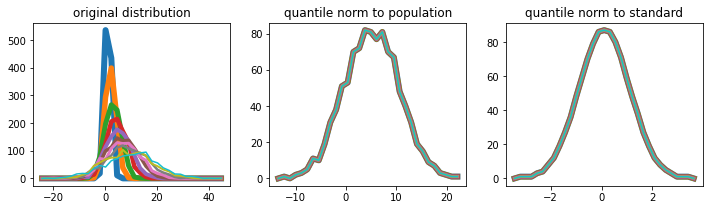

In [19]:
########## Quantile normalization: quantile_norm( x, reference ) ##########

# This is just for plots
def graph_hist(x, ip, titlename):
    b = np.arange(x.min()*1.1, x.max()*1.1, (x.max()-x.min())/30 )
    for i in range(10):
        freq = np.histogram(x[:,i],bins=b)[0]
        ax[ip].plot(b[1:],freq, linewidth=(6-i*0.5))
        ax[ip].set_title(titlename)


# Figure prep
fig, ax = plt.subplots(1, 3, figsize=(12,3))


### assuming we have 10 distributions of N elements ###
# 1 column = 1 distribution
N = 1000
x = []
for i in range(10):
    x.append(np.random.normal(i,i+1,N))
x = np.array(x).T # 1 column = 1 distribution
graph_hist(x, 0, 'original distribution')

    
### quantile normalization to population ###
x = done.quantile_norm( x, x )
graph_hist(x, 1, 'quantile norm to population')


### quantile normalization to standardized normal distribution ###
Ny =1000000
y = np.random.normal(0,1,Ny)
#from scipy import stats # for precise distribution
#p = np.arange(0, 1, 1/Ny)  + 1/(2*Ny)
#y = stats.norm.ppf(p, loc=0, scale=1)
x = done.quantile_norm( x, y )
graph_hist(x, 2, 'quantile norm to standard')